# Days since first hospitalization

- Fit the doubling time based on all other input parameters by asking the user for 1 additional input: the number of days that have passed since the first hospitalization of a COVID19 patient.
- Allows the user to line up historical predicted hospitalizations with actuals.
- Properly seeds S, I, and R at current day by starting back at the time of the first hospitalization.
- Fitting process has the advantage of being _simple_, only requiring 1 additional input from the user.

In [1]:
%pylab inline
from typing import Dict

import pandas as pd
from typing import Dict, Generator, Tuple

from scipy.stats import binom, norm
from matplotlib.pylab import plt
import seaborn as sns  # not really needed

Populating the interactive namespace from numpy and matplotlib


In [2]:
def sir(
    s: float, i: float, r: float, beta: float, gamma: float, n: float
) -> Tuple[float, float, float]:
    """The SIR model, one time step."""
    s_n = (-beta * s * i) + s
    i_n = (beta * s * i - gamma * i) + i
    r_n = gamma * i + r
    if s_n < 0.0:
        s_n = 0.0
    if i_n < 0.0:
        i_n = 0.0
    if r_n < 0.0:
        r_n = 0.0

    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale


def gen_sir(
    s: float, i: float, r: float, beta: float, gamma: float, n_days: int,
) -> Generator[Tuple[float, float, float], None, None]:
    """Simulate SIR model forward in time yielding tuples."""
    s, i, r  # = (float(v) for v in (s, i, r))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r
        s, i, r = sir(s, i, r, beta, gamma, n)


def sim_sir_df(
    s: float, i: float, r: float, beta: float, gamma: float, n_days
) -> pd.DataFrame:
    """Simulate the SIR model forward in time."""
    return pd.DataFrame(
        data=gen_sir(s, i, r, beta, gamma, n_days),
        columns=("day", "susceptible", "infected", "recovered"),
    )


def get_dispositions(
    patients: np.ndarray, rates: Dict[str, float], market_share: float,
) -> Dict[str, np.ndarray]:
    """Get dispositions of patients adjusted by rate and market_share."""
    return {key: patients * rate * market_share for key, rate in rates.items()}


def build_admits_df(n_days, dispositions) -> pd.DataFrame:
    """Build admits dataframe from Parameters and Model."""
    days = np.arange(0, n_days + 1)
    projection = pd.DataFrame({"day": days, **dispositions,})
    # New cases
    admits_df = projection.iloc[:-1, :] - projection.shift(1)
    admits_df["day"] = range(admits_df.shape[0])
    return admits_df


def build_census_df(admits_df: pd.DataFrame, lengths_of_stay) -> pd.DataFrame:
    """ALOS for each category of COVID-19 case (total guesses)"""
    n_days = np.shape(admits_df)[0]
    census_dict = {}
    for key, los in lengths_of_stay.items():
        census = admits_df.cumsum().iloc[:-los, :] - admits_df.cumsum().shift(
            los
        ).fillna(
            0
        )  # .apply(np.ceil)
        census_dict[key] = census[key]

    census_df = pd.DataFrame(census_dict)
    census_df["day"] = census_df.index
    census_df = census_df[["day", *lengths_of_stay.keys()]]
    census_df = census_df.head(n_days)
    return census_df

In [3]:
rates = {
    "hospitalized": 0.025,
    "icu": 0.0075,
    "ventilated": 0.005,
}

lengths_of_stay = {
    "hospitalized": 7,
    "icu": 9,
    "ventilated": 10,
}

population_size = 4119405
n_days_since_first_hospitalized = 17
current_hospitalized = 15


def run_projection(doubling_time):
    intrinsic_growth_rate = 2 ** (1 / doubling_time) - 1

    recovery_days = 14.0
    market_share = 0.15
    initial_i = 1 / rates["hospitalized"] / market_share
    S, I, R = population_size - initial_i, initial_i, 0
    # mean recovery rate, gamma, (in 1/days).
    gamma = 1 / recovery_days

    # Contact rate, beta
    beta = (
        intrinsic_growth_rate + gamma
    ) / S  # {rate based on doubling time} / {initial S}

    n_days = 100

    raw_df = sim_sir_df(S, I, R, beta, gamma, n_days)
    i_dict_v = get_dispositions(raw_df.infected, rates, market_share)
    r_dict_v = get_dispositions(raw_df.recovered, rates, market_share)

    dispositions = {key: value + r_dict_v[key] for key, value in i_dict_v.items()}

    dispositions_df = pd.DataFrame(dispositions)
    admits_df = admits_df = build_admits_df(n_days, dispositions)
    census_df = build_census_df(admits_df, lengths_of_stay)

    return admits_df, census_df


def obs_pred_diff(doubling_time):
    admits_df, census_df = run_projection(doubling_time)

    ## get the predicted number hospitalized today
    pred_current_hospitalized = census_df["hospitalized"].loc[
        n_days_since_first_hospitalized
    ]

    ## compare against the actual (user inputed) number
    ## squared difference is the loss to be optimized
    return (current_hospitalized - pred_current_hospitalized) ** 2

Brut force optimization, but could be implemented however. Just need to minimize the `obs_pred_diff` as a function of `doubling_times`

In [4]:
doubling_times = np.linspace(1, 15, 29)
loss = np.array([obs_pred_diff(dt) for dt in doubling_times])
fitted_doubling_time = doubling_times[loss.argmin()]
fitted_doubling_time

4.5

Then you can run the projection starting at the fitted value. This gives you a projection that starts from the day of the first hospitalization. We'll subtract off `n_days_since_first_hospitalized` to make day 0 be today.

In [5]:
admits_df, census_df = run_projection(fitted_doubling_time)
admits_df["day"] = admits_df["day"] - n_days_since_first_hospitalized
census_df["day"] = census_df["day"] - n_days_since_first_hospitalized

actual_hsp = [
    np.nan,
    1,
    1,
    1,
    1,
    1,
    2,
    2,
    2,
    2,
    4,
    4,
    7,
    6,
    8,
    13,
    13,
    15,
]
actual_hsp_array = np.array(
    actual_hsp + [np.nan for i in range(census_df.shape[0] - len(actual_hsp))]
)
census_df["actual_hospitalized"] = actual_hsp_array

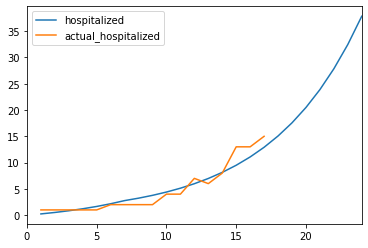

In [6]:
ax = census_df[["hospitalized", "actual_hospitalized"]].head(25).plot()

plt.show()

In [7]:
census_df.set_index("day").head(30).apply(np.ceil).astype(dtype=pd.Int64Dtype())

,hospitalized,icu,ventilated,actual_hospitalized
day,,,,
-17,NaN,NaN,NaN,NaN
-16,1,1,1,1
-15,1,1,1,1
-14,1,1,1,1
-13,2,1,1,1
-12,2,1,1,1
-11,3,1,1,2
-10,3,1,1,2
-9,4,2,1,2


# Bayesian fit

The genral idea of this section is to fit not only the `doubling_time` but also `gamma` and current infected people `I` and try to infer uncertainties of these parameters. This is done in a bayesian framework.

To allow a baysian interptretation of results, the initial data needs to be interpreted in a probablity context. A potential way to view the number of hospitalized patients is as follows:

>  think of realized hospitalizations as a binomial draw from probability (%hospitalized) and size (Current Infected).

(Thanks @cchivers)

Here I make a **strong assumption**: The probablity of being hospitalized if one is infected is 

$$
    P(\text{hos}|\text{inf}) = p_\text{hos} = 20 \% \, .
$$

The idea is that $20\%$ of known infections show strong symptoms. In other words I assume that only strong symptoms or worse are hospitalized. 
Maybe someone has a better idea for this number. One might be more systematic about this in the future, but for now, getting a kind-of-reasonable uncertainty estimate might be better than no estimate.

This assumption allows to associate errorbars to the data hospitals provide.
E.g., hospitals provide the mean value which is $n_\text{hos} = n_\text{tot} p_\text{hos}$ which allows to infer $n_\text{tot}$ and the variance thus becomes 
$$\text{var}_\text{hos} = n_\text{tot} p_\text{hos} (1-p_\text{hos}) = n_\text{hos}(1-p_\text{hos})$$

In [8]:
n_days_since_first_hospitalized = 17
ACTUAL_HOS = np.array([1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 4, 7, 6, 8, 13, 13, 15,])

P0 = 0.2
VARIANCE = ACTUAL_HOS * (1 - P0)

To run the baysian fit, I make **two simplifications**:

1. The used software utilizes normal (as in gaussian) probability distributions. Thus I approximated the binomial distributions of patient data with a (continous) gaussian distribution. The the gaussian mean and variance are set equal to the binomal mean and variance. This becomes more accurate, the larger the sample size $n$ (which seems to be a reasonable estimate given the size of initally infected people seems to be larger 200). It is possible to use Monte Carlo computations to use the  actual distributions. This might be something for the future.
2. I assume that the data points are uncorrelated. This is clearly not the case but it is hard for me to understand how to correlate binomial distributions where $n$ changes. **If someone has an idea: please help.**

In [9]:
import lsqfit
import gvar as gv

The data used for the fit

In [10]:
Y = gv.gvar(ACTUAL_HOS, np.sqrt(VARIANCE))
X = np.arange(len(Y))  # this can later be updated to actual days

A comparison of distributions

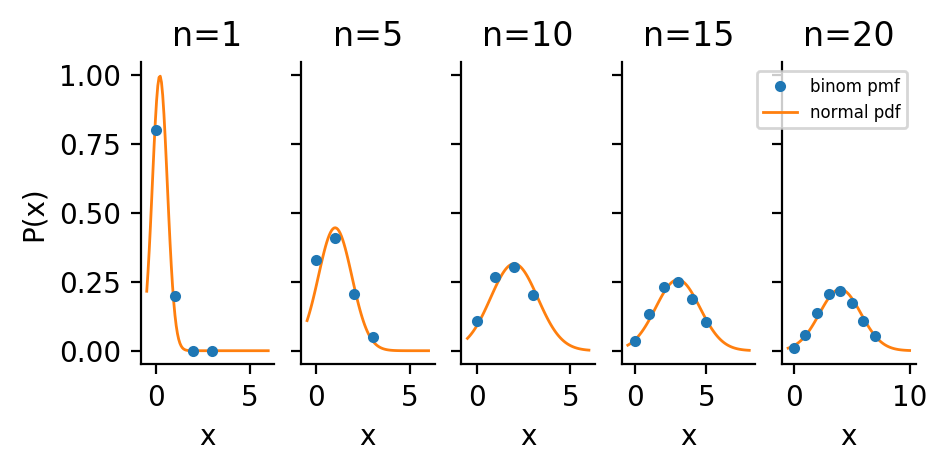

In [11]:
step = 5
fig, axs = plt.subplots(ncols=5, figsize=(5, 2), dpi=200, sharey=True)

axs[0].set_ylabel("P(x)")

for n, ax in zip([1, 5, 10, 15, 20], axs):
    x = np.arange(0, max(n * P0 * 2, 4))
    xx = np.linspace(-0.5, x.max() + 3, 100)

    ax.plot(x, binom.pmf(x, n, P0), "o", ms=3, label="binom pmf")
    ax.plot(
        xx,
        norm.pdf(xx, n * P0, np.sqrt(n * P0 * (1 - P0))),
        "-",
        lw=1,
        label="normal pdf",
        zorder=-1,
    )
    ax.set_title("n={n}".format(n=n))

    ax.set_xlabel("x")

    sns.despine()

ax.legend(bbox_to_anchor=(1, 1), fontsize=6)
plt.show()

The code below tries to fit the 

* `doubling_time`, 
* current infected `I`, 
* `recovered` and 
* `gamma` 

Again, to simplify compuatations, values are assumed to be normally distributed and the mean values are set as in the bruteforce fit.

In [12]:
population_size = 4119405
recovery_days = 14.0
market_share = 0.15
initial_i = 1 / rates["hospitalized"] / market_share

prior = {
    "i": gv.gvar(initial_i, initial_i * 0.8), # conservative 80% uncertainty
    "r": gv.gvar(0.01, 0.001), # no recovered to high prob
    "doubling time": gv.gvar(4.5, 3), # doubling in 4.5 days +/- 3 days
    "gamma": 1 / gv.gvar(recovery_days, 3), # recovery in 2 weeks +/- 3 days
}

In [13]:
MARKET_SHARE = 0.15
RATES = {
    "hospitalized": 0.025,
    "icu": 0.0075,
    "ventilated": 0.005,
}
LENGTH_OF_STAY = {
    "hospitalized": 7,
    "icu": 9,
    "ventilated": 10,
}


def run_hosp_projections(n_days: int, p: Dict[str, "Gvar"]) -> "Array[Gvar]":
    """Runs sir for prior params and returns hospitalized 
    """
    S, I, R = population_size - p["i"] - p["r"], p["i"], p["r"]

    intrinsic_growth_rate = 2 ** (1 / p["doubling time"]) - 1
    gamma = p["gamma"]
    beta = (intrinsic_growth_rate + gamma) / S

    nn_days = n_days + LENGTH_OF_STAY["hospitalized"]

    raw_df = sim_sir_df(S, I, R, beta, gamma, nn_days)

    i_dict_v = get_dispositions(raw_df.infected, RATES, MARKET_SHARE)
    r_dict_v = get_dispositions(raw_df.recovered, RATES, MARKET_SHARE)

    dispositions = {key: value + r_dict_v[key] for key, value in i_dict_v.items()}

    dispositions_df = pd.DataFrame(dispositions)
    admits_df = build_admits_df(nn_days, dispositions).drop(0)

    census_df = build_census_df(admits_df, lengths_of_stay).head(
        -LENGTH_OF_STAY["hospitalized"]
    )

    return census_df["hospitalized"].values


def fcn(x: np.ndarray, p: Dict[str, "Gvar"]):
    """Wraps run_hosp_projections by truning days array to n_days.
    
    Should be updated later if time projection data is available.
    """
    return run_hosp_projections(len(x), p)

run_hosp_projections(15, prior)

array([0.24(23), 0.52(50), 0.84(85), 1.2(1.3), 1.7(1.8), 2.2(2.5),
       2.8(3.3), 3.2(4.1), 3.8(5.1), 4.4(6.3), 5.1(7.8), 6.0(9.6), 7(12),
       8(15), 9(18)], dtype=object)

Run the fit

In [14]:
res = lsqfit.nonlinear_fit(data=(X, Y), fcn=fcn, prior=prior)

And present results

In [15]:
outputs = {key: val for key, val in res.p.items()}
inputs = dict(Y=Y)
inputs.update(prior)

print(
    res, "\n" * 2, gv.fmt_values(res.p), "\n" * 2, gv.fmt_errorbudget(outputs, inputs, percent=True)
)

Least Square Fit:
  chi2/dof [dof] = 0.28 [17]    Q = 1    logGBF = -30.252

Parameters:
              i      135 (57)     [   267 (213) ]  
              r   0.0100 (10)     [ 0.0100 (10) ]  
  doubling time     3.45 (49)     [   4.5 (3.0) ]  
          gamma    0.071 (15)     [  0.071 (15) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 7/0.4)
  fitter = scipy_least_squares    method = trf
 

 Values:
                  i: 135(57)             
                  r: 0.0100(10)          
      doubling time: 3.45(49)            
              gamma: 0.071(15)           
 

 Partial % Errors:
                           i             r doubling time         gamma
----------------------------------------------------------------------
            Y:         39.54          0.00         13.50          0.18
            i:         11.13          0.00          3.63          0.66
            r:          0.00         10.00          0.00          0.00
doubling time:

The above table describes how errors propagate.
E.g., `r` has a 10% error which comes solely from the prior assumptions. Generally one wants that data informs parmeters (and not priors), but in this case no recovered cases before we knew about the infections seems reasobale.

The data strongly influences the doubling time and it seems that the brute force fit with $dt = 4.5 \approx 4.47(22)$ indeed seems like a quite good estimate. For other parameters I'd argue that the data is not sufficient right now to pinpoint parameters. Adding correlation would very likely improve results.

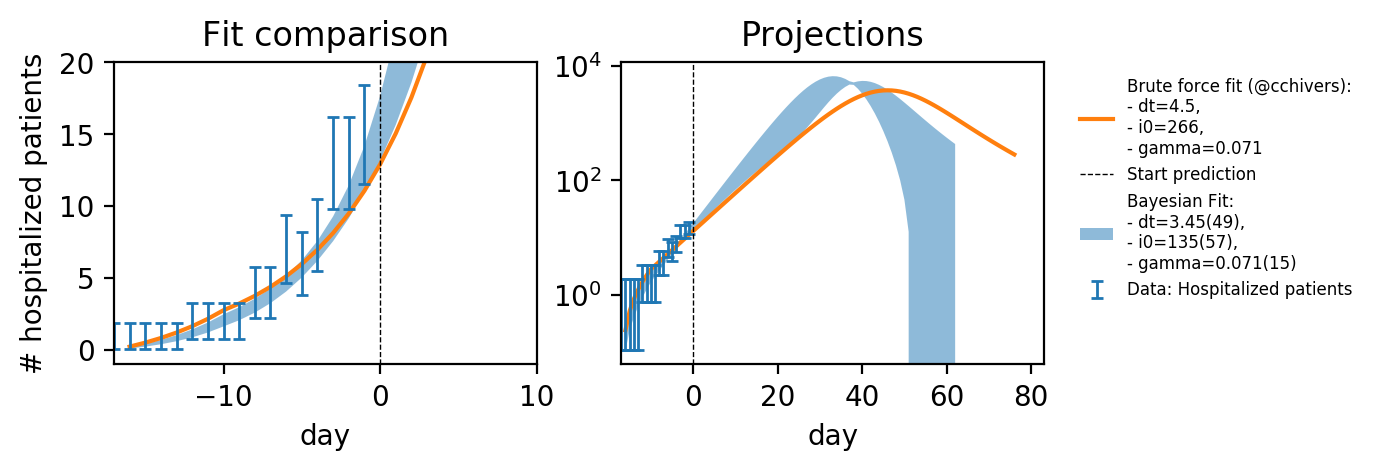

In [16]:
fig, axs = plt.subplots(dpi=200, figsize=(6, 2), ncols=2)

x_projection = np.arange(1, 80)
y_fit = fcn(x_projection, res.p)


ax = axs[0]
ax.set_title("Fit comparison")
ax.errorbar(
    X - n_days_since_first_hospitalized,
    gv.mean(Y),
    gv.sdev(Y),
    marker=".",
    ms=0,
    capsize=2,
    ls="None",
    lw=1,
)
ax.fill_between(
    x_projection - n_days_since_first_hospitalized,
    gv.mean(y_fit) - gv.sdev(y_fit),
    gv.mean(y_fit) + gv.sdev(y_fit),
    alpha=0.5,
    zorder=-1,
)
census_df.set_index("day")["hospitalized"].plot(
    ax=ax, zorder=-1,
)
ax.set_xlim(-n_days_since_first_hospitalized, 10)
ax.set_ylim(-1, 20)
ax.axvline(0, color="black", ls="--", lw=0.5)
ax.set_ylabel("# hospitalized patients")

ax = axs[1]
ax.set_title("Projections")
ax.errorbar(
    X - n_days_since_first_hospitalized,
    gv.mean(Y),
    gv.sdev(Y),
    marker=".",
    ms=0,
    lw=1,
    capsize=2,
    ls="None",
    label="Data: Hospitalized patients",
)
ax.fill_between(
    x_projection - n_days_since_first_hospitalized,
    gv.mean(y_fit) - gv.sdev(y_fit),
    gv.mean(y_fit) + gv.sdev(y_fit),
    alpha=0.5,
    zorder=-1,
    label=f"Bayesian Fit:\n- dt={outputs['doubling time']},\n- i0={outputs['i']},\n- gamma={outputs['gamma']}",
)
census_df.set_index("day")["hospitalized"].plot(
    ax=ax,
    zorder=-1,
    label="Brute force fit (@cchivers):\n- dt={fitted_doubling_time},\n- i0={i0:d},\n- gamma={gamma:1.3f}".format(
        fitted_doubling_time=fitted_doubling_time,
        i0=int(1 / rates["hospitalized"] / market_share),
        gamma=1 / recovery_days,
    ),
)
ax.axvline(0, color="black", ls="--", lw=0.5, label="Start prediction")

ax.set_yscale("log", basey=10)
ax.legend(fontsize=6, bbox_to_anchor=(1.05, 1.0), frameon=False)

plt.show()